In [1]:
# load data into df
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
orders = pd.read_csv('orders_competition.csv')
clients = pd.read_csv('clients_competition.csv')

### Data preprocessing

In [10]:
clients['Is Dormant'] = clients['Is Dormant'].replace(-1.0, 1)
clients['Is Dormant'] = clients['Is Dormant'].replace(0.0, 0)
# use astype to convert to int
clients['Is Dormant'] = clients['Is Dormant'].astype(int)
clients.head()

# join orders and clients on Account ID
merged = pd.merge(orders, clients, on='Account ID', how='inner')


/Users/Omar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/Omar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/Omar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


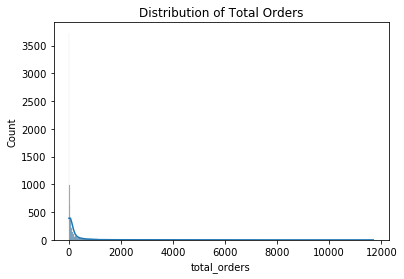

/Users/Omar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/Omar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/Omar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


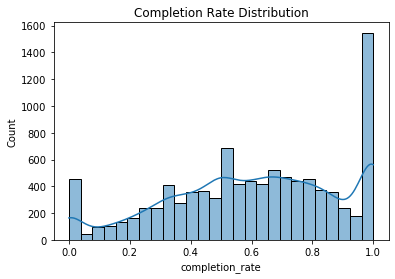

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming orders is already loaded
# Calculate summary stats for orders
order_summary = orders.groupby('Account ID').agg({
    'Order ID': 'count',
    'Is Completed': 'mean',
    'Is Canceled': 'mean',
    'quantity': 'mean',
    'Price': 'mean'
}).rename(columns={'Order ID': 'total_orders', 'Is Completed': 'completion_rate', 
                   'Is Canceled': 'cancel_rate', 'quantity': 'avg_quantity', 'Price': 'avg_price'})

# Merge with clients
full_data = pd.merge(clients, order_summary, on='Account ID', how='left')

# Plot distributions of order behaviors
sns.histplot(full_data['total_orders'].dropna(), kde=True)
plt.title('Distribution of Total Orders')
plt.show()

sns.histplot(full_data['completion_rate'].dropna(), kde=True)
plt.title('Completion Rate Distribution')
plt.show()


In [11]:
# Calculate churn
clients['Churned'] = np.where(clients['Is Dormant'] == 1 | clients['Is Closed'], 1, 0)



# Join with orders
merged = pd.merge(orders, clients, on='Account ID', how='inner')

churned_clients = merged[merged['Churned'] == 1]
last_activity = churned_clients.groupby('Account ID')['Order Date'].max().reset_index()
last_activity.columns = ['Account ID', 'Closed Date']

# Merge with clients
clients = pd.merge(clients, last_activity, on='Account ID', how='left')





KeyError: 'Column not found: Order Date'

In [9]:
clients.head()

,Client ID,Account ID,Gender,Risk Rate,Company Name,Is Closed,Is Dormant,Is Profile Suspended,Is Client Suspended,Client Type Name,OpenDate,BirthDate,Churned
0,0,0,Male,Low,HSB,0,0.0,0,0,Individuals,2/16/2014,1990-07-27,0
1,1,1,Female,Low,HSB,0,-1.0,1,0,Individuals,2/16/2014,1963-10-22,0
2,2,2,Male,Low,HSB,0,0.0,0,0,Individuals,2/17/2014,1971-05-14,0
3,3,3,Male,Low,HSB,0,0.0,0,0,Individuals,2/17/2014,1953-01-14,0
4,4,4,Male,Low,HSB,0,0.0,0,0,Individuals,2/17/2014,1976-06-09,0


### Cohort analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'full_data' is your DataFrame and it includes 'OpenDate' and 'Churn' columns
# Convert 'OpenDate' to datetime if it's not already
full_data['OpenDate'] = pd.to_datetime(full_data['OpenDate'])

# Extract the year and month/quarter from 'OpenDate' for cohort grouping
full_data['Cohort'] = full_data['OpenDate'].dt.to_period('M')  # Use 'Q' for quarter

# Group by cohort and calculate churn rates and average activity
cohort_data = full_data.groupby('Cohort').agg(
    total_customers=pd.NamedAgg(column='Account ID', aggfunc='count'),
    churn_rate=pd.NamedAgg(column='Is Closed', aggfunc='mean')  # Assuming 'Is Closed' is a binary indicator of churn
)

# Calculate how long customers stay before churning
# This assumes you have a 'ClosedDate' for when accounts are closed; adjust as necessary
# If no specific close date, consider the last activity date or similar
if 'ClosedDate' in full_data.columns:
    full_data['ClosedDate'] = pd.to_datetime(full_data['ClosedDate'])
    full_data['Duration'] = (full_data['ClosedDate'] - full_data['OpenDate']).dt.days
    duration_by_cohort = full_data.groupby('Cohort')['Duration'].mean()
    cohort_data = cohort_data.join(duration_by_cohort)

# Visualizing the results
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
cohort_data['total_customers'].plot(kind='bar', ax=ax[0], color='skyblue', title='Total Customers by Cohort')
cohort_data['churn_rate'].plot(kind='bar', ax=ax[1], color='orange', title='Churn Rate by Cohort')
plt.tight_layout()
plt.show()

# If Duration analysis is applicable
if 'Duration' in cohort_data.columns:
    cohort_data['Duration'].plot(kind='bar', color='green', title='Average Duration before Churning by Cohort')
    plt.show()
